---
# A notebook to sort the mess of the naming scheme for the imagery dataset.
---
<a id='back_to_top'></a>

## Major sections
* [0. Preliminary Setup](#prim_setup)                       
* [1. Prepare the stimuli](#stimuli)
* [2. Prepare the voxel responses](#voxels)

In [22]:
import sys
import os
import time
import numpy as np
import h5py
from scipy import ndimage as nd
from scipy.io import loadmat ##
from tqdm import tqdm
import pickle
import math
import PIL.Image as pim
import matplotlib.pyplot as plt
%matplotlib inline

import src.file_utility as pfu

<a id='prim_setup'></a>
## Preliminary setup: Target files

In [2]:
project = 'imagery_rf'
subject    = 'CO'
subject_dir = 'CO_new'
dataset_dir = "/home/styvesg/Documents/PostDoc/Datasets/imagery_rf/%s/" % subject_dir
stimuli_dir = "/home/styvesg/Documents/PostDoc/Datasets/imagery_rf/stimuli/"

condit_file_name     = "%s_condit_names.mat" % subject
betas_file_name      = "%s_all_runs_BETAs.mat" % subject
roi_prob_mask_name   = "vox_by_ROI_%s.mat" % subject
brain_mask_file_name = "%s_mean_func_brain_pt1_mask_fixed.nii" % subject
roi_mask_file_name   = "%s_ROIprob_by_vol.nii.gz" % subject
voxel_mask_file_name   = None #"%s_10kastDial_mythick_0pt05RibbonMask_plusOldCombo.nii.gz" % subject #"CO_myROIs_both_byVAL_inFUNCspace.nii.gz"
kast_roi_mask_file_name   = None

## Map definitions

In [3]:
# the map of the indices in the file to the named ROI
roi_map = {0: 'V1v_L', 1: 'V1v_R', 2: 'V1d_L', 3: 'V1d_R',
           4: 'V2v_L', 5: 'V2v_R', 6: 'V2d_L', 7: 'V2d_R',
           8: 'V3v_L', 9: 'V3v_R', 10: 'V3d_L', 11: 'V3d_R',
           12: 'hV4_L', 13: 'hV4_R',
           14: 'VO1_L', 15: 'VO1_R', 16: 'VO2_L', 17: 'VO2_R',
           18: 'PHC1_L', 19: 'PHC1_R', 20: 'PHC2_L', 21: 'PHC2_R',
           22: 'MST_L', 23: 'MST_R', 24: 'hMT_L', 25: 'hMT_R',
           26: 'LO_L_null', 27: 'LO_R_null', 28: 'LO_L', 29: 'LO_R', 
           30: 'V3b_L', 31: 'V3b_R', 32: 'V3a_L', 33: 'V3a_R',
           34: 'IPS0_L', 35: 'IPS0_R',
           36: 'IPS1_L', 37: 'IPS1_R',
           38: 'IPS2_L', 39: 'IPS2_R',
           40: 'IPS3_L', 41: 'IPS3_R',
           42: 'IPS4_L', 43: 'IPS4_R',
           44: 'IPS5_L', 45: 'IPS5_R',
           46: 'SPL1_L', 47: 'SPL1_R'}

# the code used in the image name to denote the position of the picture in the image.
ori_map = {'north': 0, 'west': 1, 'southwest': 2, 'northwest': 3, 'east': 4, 'south': 5, 'northeast': 6, 'southeast': 7}

<a id='stimuli'></a>
# 1. Prepare the stimuli

[back to top](#back_to_top)

In [37]:
condit_names = loadmat(dataset_dir + condit_file_name)

seq, clo, ori = [],[],[]
for i,s in enumerate(condit_names['all_cur_subj_condits'][0,:]):
    iseq, icls, iobj, iori = s[0].split('/')
    seq += [iseq,]
    clo += [('imagery_%03d/' % int(s[0][0]) +icls+'.'+iobj).replace(',','_').replace(' ','_'),]
    ori += [iori,]   
# conversion between the file structure and image name code
templates = []
for i in range(1,9):
    folder = stimuli_dir + 'imagery_%03d/' % i
    templates += [fn.split('/')[-2:] for fn in pfu.list_files(folder) if '.png' in fn]
print "  Found %d objects" % len(templates)
# object map
clo_map = {}
for fn,t in templates:
    tok = t.split('.')
    clo_map[(fn+'/'+tok[0]+'.'+tok[1]).replace(',','_').replace(' ','_')] = tok[3]+'.'+tok[2]
print "  Conversion of Object/Session to image name code."
#print clo_map
lab_map, seq_map = {},{}
for fn, t in templates:
    tok = t.split('.')
    f = open(stimuli_dir + '/%s/%s.txt' % (fn, tok[3]))
    lab_map[(fn+'/'+tok[0]+'.'+tok[1]).replace(',','_').replace(' ','_')] = f.read()
    f.close()
for i in range(1,9):
    for s in ['pcp', 'img']:
        seq_map['%d%s' % (i,s)] = ('imagery_%03d/frame_files' % i, 'cue' if s=='img' else 'image', i, s)
print "  Breakdown of the session token into (subfolder, presentation, run, type)." 
#print seq_map
stim_files, stim_label, stim_exp, stim_seq = [],[],[],[]
for s,c,o in zip(seq, clo, ori):
    sub,ext,e,s = seq_map[s]
    stim_files += ['%s/%s.%02d.%s.png' % (sub,clo_map[c],ori_map[o],ext),]
    stim_label += [lab_map[c][:6],] # shorten the label to 6 letters, removing the carriage return
    stim_exp += [e,]
    stim_seq += [s,]
print "  Reconstruction of the file name, orientation and picture."
print "  %d images" % len(stim_files)

  Found 64 objects
  Conversion of Object/Session to image name code.
  Breakdown of the session token into (subfolder, presentation, run, type).
  Reconstruction of the file name, orientation and picture.
  1024 images


## Now that we have a regular file list, we can load all these files and concatenate them into a regular array.

In [11]:
npc = 3
npx = 600

def processImage(f, npx):
    im = pim.open(f)
    return np.asarray(pfu.center_crop(im.convert('RGB')).resize((npx, npx), resample=pim.BILINEAR))

stim_data = np.ndarray(shape=(len(stim_files), npx, npx, npc), dtype=np.uint8)
for i,f in enumerate(stim_files): 
    stim_data[i,...] = processImage(stimuli_dir + f, npx)

## Display an example image with the tokens that we've extracted from the file name

cue shown               : picgrp
experimental run        : 8
experiment type         : pcp
position                : northeast
unique object identifier: imagery_008/many_humans.people


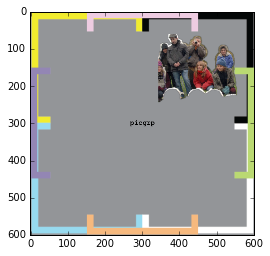

In [20]:
plt.imshow(stim_data[-1])
print "Cue shown               : %s" % stim_label[-1]
print "Experimental run        : %s" % stim_exp[-1]
print "Experiment type         : %s" % stim_seq[-1]
print "Position                : %s" % ori[-1]
print "Unique object identifier: %s" % clo[-1]

## Save to disk
Stimuli_metadata.pkl is all the irregular dictionaries characterizing the inputs while the regular inputs are saved under "Stimuli.h5py"

In [56]:
stim_file_name = dataset_dir + "Stimuli_metadata.pkl"
stim_file = open(stim_file_name, 'wb')
stim_dict = {
    'project': project,
    'label': stim_label,
    'ori': ori,
    'exp': stim_exp,
    'seq': stim_seq,
    'clo': clo,
    'orimap': ori_map,
    'clomap': clo_map
}
pickle.dump(stim_dict, stim_file)
stim_file.close()
print stim_file_name

/home/styvesg/Documents/PostDoc/Datasets/imagery_rf/LF/Stimuli_metadata.pkl


In [ ]:
pfu.save_stuff(dataset_dir + "Stimuli", {'stim': stim_data})

<a id='voxels'></a>
# 2. Prepare the voxel responses

[back to top](#back_to_top)

## Load brain mask and ROI masks

In [29]:
full_brain_mask = pfu.load_mask_from_nii(dataset_dir+brain_mask_file_name)
roi_prob_masks = loadmat(dataset_dir + roi_prob_mask_name)['vox_by_ROI']
print "ROI masks shape      : %s" % (roi_prob_masks.shape,)

roi_max_mask = np.argmax(roi_prob_masks, axis=1)
roi_max_mask[np.sum(roi_prob_masks, axis=1)==0] = -1
print "argmax ROI mask shape: %s" % (roi_max_mask.shape,)

ROI masks shape      : (349839, 48)
argmax ROI mask shape: (349839,)


## Load voxel data and verify integrity

In [31]:
voxelset = loadmat(dataset_dir+betas_file_name)
print voxelset.keys()
whole_brain_voxel_data = voxelset['all_runs_matrix'].T # re-orient to [samples, voxels]

voxelNanMask = ~np.isnan(whole_brain_voxel_data).any(axis=0)
nv = np.sum(voxelNanMask)
print "%d voxels for all images" % len(voxelNanMask)
print "%d voxels contain valid values for all images" % nv

voxel_data = whole_brain_voxel_data[:, voxelNanMask].astype(dtype=np.float32)
print "All voxel responses shape: %s" % (voxel_data.shape,)

['all_runs_matrix', '__version__', '__header__', '__globals__']
349839 voxels for all images
349839 voxels contain valid values for all images
All voxel responses shape: (1024, 349839)


## Create the ROI-only voxel mask

In [32]:
full_brain_shape = full_brain_mask.shape
full_brain_mask = full_brain_mask.flatten(order='F')
print "Brain volume shape: %s" % (full_brain_shape,)

idx_mask = np.arange(full_brain_mask.size)[full_brain_mask==1]
assert len(idx_mask)==nv, "nv = %d != %d" % (nv, len(idx_mask))

#voxel_mask = full_voxel_mask.flatten(order='F')[full_brain_mask==1]
voxel_mask = (roi_max_mask>=0)
assert len(voxel_mask)==nv
print "total voxel count = %d" % nv
print "voxel count in ROIs = %d" % np.sum(voxel_mask)

Brain volume shape: (130, 130, 70)
total voxel count = 349839
voxel count in ROIs = 46909


---
## Display the ROI-only voxel mask and the individual ROIs

In [33]:
volume_voxel = pfu.view_data(full_brain_shape, idx_mask, voxel_mask)
volume_roi = pfu.view_data(full_brain_shape, idx_mask, roi_max_mask)

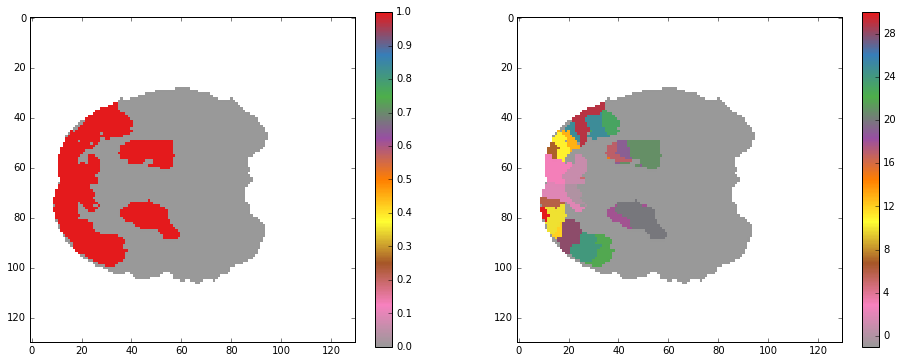

In [34]:
fig = plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.imshow(volume_voxel[:,:,15], cmap='Set1_r', interpolation='None')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(volume_roi[:,:,15], cmap='Set1_r', interpolation='None')
plt.colorbar()
#plt.grid('off')

---

## Save to disk
Voxels_metadata.pkl is all the irregular dictionaries characterizing the data while the responses are saved under "Voxels.h5py"

In [19]:
voxel_file_name = dataset_dir + "Voxels_metadata.pkl"
voxel_file = open(voxel_file_name, 'wb')
voxel_dict = {'project': project, 
              'subject': subject,
              'idxs': idx_mask,
              'brain_mask': full_brain_mask, # mask that masks the brain in the 'volume' space
              'grid': full_brain_shape, # the shape of the grid in 'volume' space
              'voxel_mask': voxel_mask, 
              'roi_mask': roi_max_mask,
              'roi_map': roi_map}
pickle.dump(voxel_dict, voxel_file)
voxel_file.close()
print voxel_file_name

/home/styvesg/Documents/PostDoc/Datasets/imagery_rf/CO_new/Voxels_metadata.pkl


In [20]:
pfu.save_stuff(dataset_dir + "Voxels", {'betas': voxel_data})

saved betas in h5py file


[back to top](#back_to_top)